In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))
from config import *

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from ssqa import *
from data import *
from pgm import *


warnings.filterwarnings("ignore")

In [3]:
DATASET = "BLAT_ECOLX"
MUT_DATASET = "BLAT_ECOLX"
DATA = MUT_DATA
batch_size = 16

In [4]:
nat_seq = "HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
uniprot_id = "P62593"
pattern = c_pattern3, n_pattern3, c_pattern8, n_pattern8 = search_pattern(f"{DATA}/{MUT_DATASET}", uniprot_id, nat_seq)[0]

263


In [ ]:
infer_pattern(f"{DATA}/{DATASET}", [0])

## Pattern Matching

In [5]:
dataset = SSQAData_QA(f"{DATA}/{DATASET}/data.pt")
dataset_rbm = SSQAData_RBM(f"{DATA}/{DATASET}/data.pt")

loader = DataLoader(dataset, batch_size = 16, shuffle = False)

device = torch.device('cuda')

model_ss = NetSurfP2(50, "netsurfp2")
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))
model_ss = model_ss.to(device)

model_ss

Available :  seq L seq_hmm pattern
Available :  seq L seq_hmm pattern


Model netsurfp2-50

In [6]:
family = "BLAT_ECOLX"
name_dataset = "Palzkill2012"
exp = "ddG_stat"

mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna


In [7]:
dataset = SSQAData_QA(f"{MUT_DATA}/{family}/{name_dataset}_data.pt")

seq_hmm = dataset.seq_hmm
size = seq_hmm.size(-1)

SS_HMM3 = torch.ones(3, size) / 3
SS_HMM8 = torch.ones(8, size) / 8
ss_hmm = torch.tensor(dataset[0]).float()
active_idx = torch.where((ss_hmm[:20].sum(0) > 0))[0]
pred = model_ss(ss_hmm[None, :, active_idx].cuda())
SS_HMM3[:, active_idx] = F.softmax(pred[2][0], 0).cpu()
SS_HMM8[:, active_idx] = F.softmax(pred[1][0], 0).cpu()
SS_HMM3 = SS_HMM3[None]
SS_HMM8 = SS_HMM8[None]
X = torch.cat([data[None] for data in dataset], 0)
ssqa = SSQA(model_ss, pattern, seq_hmm, SS_HMM3, SS_HMM8)

dp, pm = ssqa.featuring(X)
mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna
y = mut_df[~isnaexp][exp].values
edca = torch.tensor(mut_df["effect_prediction_epistatic"][~isnaexp]).float()
eind = torch.tensor(mut_df["effect_prediction_independent"][~isnaexp]).float()

Available :  seq L seq_hmm


In [77]:
from scipy.stats import spearmanr, rankdata
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support


def best_temperature(X, y):
    e, dpunsup, pmunsup, dpsup, pmsup = X
    clf = LogisticRegression(fit_intercept=False)
    clf.fit(torch.cat([e[:, None], dpunsup[:, None], pmunsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wunsup = 1, b / a, c / a
    clf.fit(torch.cat([e[:, None], dpsup[:, None], pmsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wsup = 1, b / a, c / a
    return Wunsup, Wsup

def compute_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return auc(fpr, tpr)

def cv_spearmanr(ssqa, edca, dp, pm, y, N=5):
    cv = KFold(n_splits=N, shuffle=True)
    rho_scores = {"E": 0, "sup/DP": 0, "sup/PM": 0, "sup/PM+DP": 0, "sup/E+DP": 0, "sup/E+PM": 0, "sup/E+DP+PM": 0,
                  "unsup/DP": 0, "unsup/PM": 0, "unsup/PM+DP": 0, "unsup/E+DP": 0, "unsup/E+PM": 0, "unsup/E+DP+PM": 0}
    dpunsup_, pmunsup_, dpsup_, pmsup_ = torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float()
    for i, (train_index, test_index) in enumerate(cv.split(edca)):
        ssqa.train(dp[train_index], pm[train_index], y[train_index])
        e = torch.tensor(edca[test_index])
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp[test_index], pm[test_index])
        dpunsup_[test_index], pmunsup_[test_index], dpsup_[test_index], pmsup_[test_index] = dpunsup.float(), pmunsup.float(), dpsup.float(), pmsup.float()
        y_test = y[test_index]
        (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature(
            [e, dpunsup, pmunsup, dpsup, pmsup], y_test)
        print((wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm))
        
        rho_scores["E"] += np.abs(spearmanr(y_test, e)[0]) / N

        rho_scores["sup/DP"] += np.abs(spearmanr(y_test, dpsup)[0]) / N
        rho_scores["sup/PM"] += np.abs(spearmanr(y_test, pmsup)[0]) / N
        rho_scores["sup/PM+DP"] += np.abs(spearmanr(y_test, ws_dp * dpsup + ws_pm * pmsup)[0]) / N
        rho_scores["sup/E+DP"] += np.abs(spearmanr(y_test, ws_e * e + ws_dp * dpsup)[0]) / N
        rho_scores["sup/E+PM"] += np.abs(spearmanr(y_test, ws_e * e + ws_pm * pmsup)[0]) / N
        rho_scores["sup/E+DP+PM"] += np.abs(spearmanr(y_test, ws_e * e + ws_dp * dpsup + ws_pm * pmsup)[0]) / N

        rho_scores["unsup/DP"] += np.abs(spearmanr(y_test, dpunsup)[0]) / N
        rho_scores["unsup/PM"] += np.abs(spearmanr(y_test, pmunsup)[0]) / N
        rho_scores["unsup/PM+DP"] += np.abs(spearmanr(y_test, wu_dp * dpunsup + wu_pm * pmunsup)[0]) / N
        rho_scores["unsup/E+DP"] += np.abs(spearmanr(y_test, wu_e * e + ws_dp * dpunsup)[0]) / N
        rho_scores["unsup/E+PM"] += np.abs(spearmanr(y_test, wu_e * e + ws_pm * pmunsup)[0]) / N
        rho_scores["unsup/E+DP+PM"] += np.abs(spearmanr(y_test, wu_e * e + wu_dp * dpunsup + wu_pm * pmunsup)[0]) / N
    return rho_scores, dpunsup_, pmunsup_, dpsup_, pmsup_,

def cv_spearmanr(ssqa, edca, dp, pm, y, N=5):
    cv = KFold(n_splits=N, shuffle=True)
    rho_scores = {"E": 0, "sup/DP": 0, "sup/PM": 0, "sup/PM+DP": 0, "sup/E+DP": 0, "sup/E+PM": 0, "sup/E+DP+PM": 0,
                  "unsup/DP": 0, "unsup/PM": 0, "unsup/PM+DP": 0, "unsup/E+DP": 0, "unsup/E+PM": 0, "unsup/E+DP+PM": 0}
    dpunsup_, pmunsup_, dpsup_, pmsup_ = torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float()
    for i, (train_index, test_index) in enumerate(cv.split(edca)):
        ssqa.train(dp[train_index], pm[train_index], y[train_index])
        e = torch.tensor(edca[test_index])
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp[test_index], pm[test_index])
        dpunsup, pmunsup, dpsup, pmsup = dpunsup.float(), pmunsup.float(), torch.tensor(dpsup).float(), torch.tensor(pmsup).float()
        dpunsup_[test_index], pmunsup_[test_index], dpsup_[test_index], pmsup_[test_index] = dpunsup, pmunsup, dpsup, pmsup
        y_test = y[test_index]
        (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature(
            [e, dpunsup, pmunsup, dpsup, pmsup], y_test)
        print((wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm))
        
        rho_scores["E"] += np.abs(compute_auc(y_test, e)) / N

        rho_scores["sup/DP"] += np.abs(compute_auc(y_test, dpsup)) / N
        rho_scores["sup/PM"] += np.abs(compute_auc(y_test, pmsup)) / N
        rho_scores["sup/PM+DP"] += np.abs(compute_auc(y_test, ws_dp * dpsup + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup)) / N
        rho_scores["sup/E+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup + ws_pm * pmsup)) / N

        rho_scores["unsup/DP"] += np.abs(compute_auc(y_test, dpunsup)) / N
        rho_scores["unsup/PM"] += np.abs(compute_auc(y_test, pmunsup)) / N
        rho_scores["unsup/PM+DP"] += np.abs(compute_auc(y_test, wu_dp * dpunsup + wu_pm * pmunsup)) / N
        rho_scores["unsup/E+DP"] += np.abs(compute_auc(y_test, wu_e * e + ws_dp * dpunsup)) / N
        rho_scores["unsup/E+PM"] += np.abs(compute_auc(y_test, wu_e * e + ws_pm * pmunsup)) / N
        rho_scores["unsup/E+DP+PM"] += np.abs(compute_auc(y_test, wu_e * e + wu_dp * dpunsup + wu_pm * pmunsup)) / N
    return rho_scores, dpunsup_, pmunsup_, dpsup_, pmsup_,

In [72]:
y = torch.tensor((mut_df[~isnaexp][exp].values < 0.5)).int()


In [78]:
#rho_scores_ind  = cv_spearmanr(ssqa, eind, dp, pm, y)
rho_scores_dca, dpunsup_, pmunsup_, dpsup_, pmsup_ = cv_spearmanr(ssqa, edca, dp, pm, y)

for k, v in rho_scores_dca.items():
    print(f"{k} : {v:.3f}")

(1, 0.19293572679841367, 0.0639448102391294) (1, 5.636928714447894, 3.0739382109461237)
(1, 0.1953063625225448, 0.1451996054443425) (1, 4.5084717954578535, 3.1331252889763053)
(1, -0.39334377578107266, -0.3138718989441185) (1, 5.6309493463278635, 3.2901078128534955)
(1, 0.33387364835313177, 0.30192469753737855) (1, 5.489004333038113, 4.450115829407197)
(1, -0.0892524959863058, -0.15062058905909545) (1, 4.779395298114747, 5.413313630971836)
E : 0.772
sup/DP : 0.727
sup/PM : 0.723
sup/PM+DP : 0.746
sup/E+DP : 0.828
sup/E+PM : 0.806
sup/E+DP+PM : 0.847
unsup/DP : 0.515
unsup/PM : 0.491
unsup/PM+DP : 0.508
unsup/E+DP : 0.773
unsup/E+PM : 0.772
unsup/E+DP+PM : 0.773


In [79]:
ws_e, ws_dp, ws_pm = 1, 5, 3.5

## Single Mutations

In [80]:
x = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : int(x[1:-1]) if len(x) > 2 else -1).values
y = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : AA_IDS[x[-1]] if len(x) > 2 else -1).values

In [81]:
heatmap_edca = torch.zeros(len(nat_seq), 20)
heatmap_ssqa = torch.zeros(len(nat_seq), 20)
heatmap_both = torch.zeros(len(nat_seq), 20)
target = torch.zeros(len(nat_seq), 20)

In [63]:
target.sum(1)

tensor([ 0.,  0.,  0.,  0.,  0., 13., 18., 18., 18.,  9., 19., 19., 19., 19.,
        19., 19., 19., 17., 18., 19., 19., 16., 12., 17., 19., 17., 16., 16.,
        19., 18., 19., 16.,  0., 17., 15., 19., 17., 13., 19., 19., 19., 19.,
        19., 19., 17., 19., 19., 19., 18., 19., 19., 19., 18., 16., 17., 19.,
        10., 19., 19., 19., 19., 19., 18., 19., 15., 18., 15., 19., 17., 18.,
        19., 19., 14., 19., 15., 19., 18., 17., 19., 19., 19., 19., 18., 19.,
        19., 19., 19., 11., 14., 19., 19., 19., 19., 18.,  8., 19., 19., 19.,
         9., 19., 19., 18., 19., 19., 19., 19., 19., 18., 19., 19., 19., 17.,
        19., 19., 10., 19., 19., 19., 19., 19., 15., 17., 19., 19., 12., 16.,
        18., 19., 19., 18., 19., 19., 15.,  8., 19., 19., 19., 19., 19., 19.,
        19., 18., 18., 19., 19., 11., 19., 17., 15., 16., 19., 16., 19., 19.,
        19., 19., 17., 19., 16., 17., 19., 19., 10., 18., 19., 15., 16., 19.,
        17., 14., 19., 19., 19., 19., 19.,  3.,  7., 18., 19., 1

In [82]:
edca_0 = 0
ssqa_0 = 0
both_0 = 0
for k, (i, j, e, t, dpsup, pmsup) in enumerate(zip(x, y, edca, torch.tensor((mut_df[~isnaexp][exp].values < 0.5)).int(), dpsup_, pmsup_)):
    if k == 0:
        edca_0 = e
        ssqa_0 = ws_dp * dpsup + ws_pm * pmsup
        both_0 = edca_0 + ssqa_0
    target[i,j] = t
    heatmap_edca[i,j] = e - edca_0
    heatmap_ssqa[i,j] = (ws_dp * dpsup + ws_pm * pmsup) - ssqa_0
    heatmap_both[i,j] = (e + ws_dp * dpsup + ws_pm * pmsup) - both_0

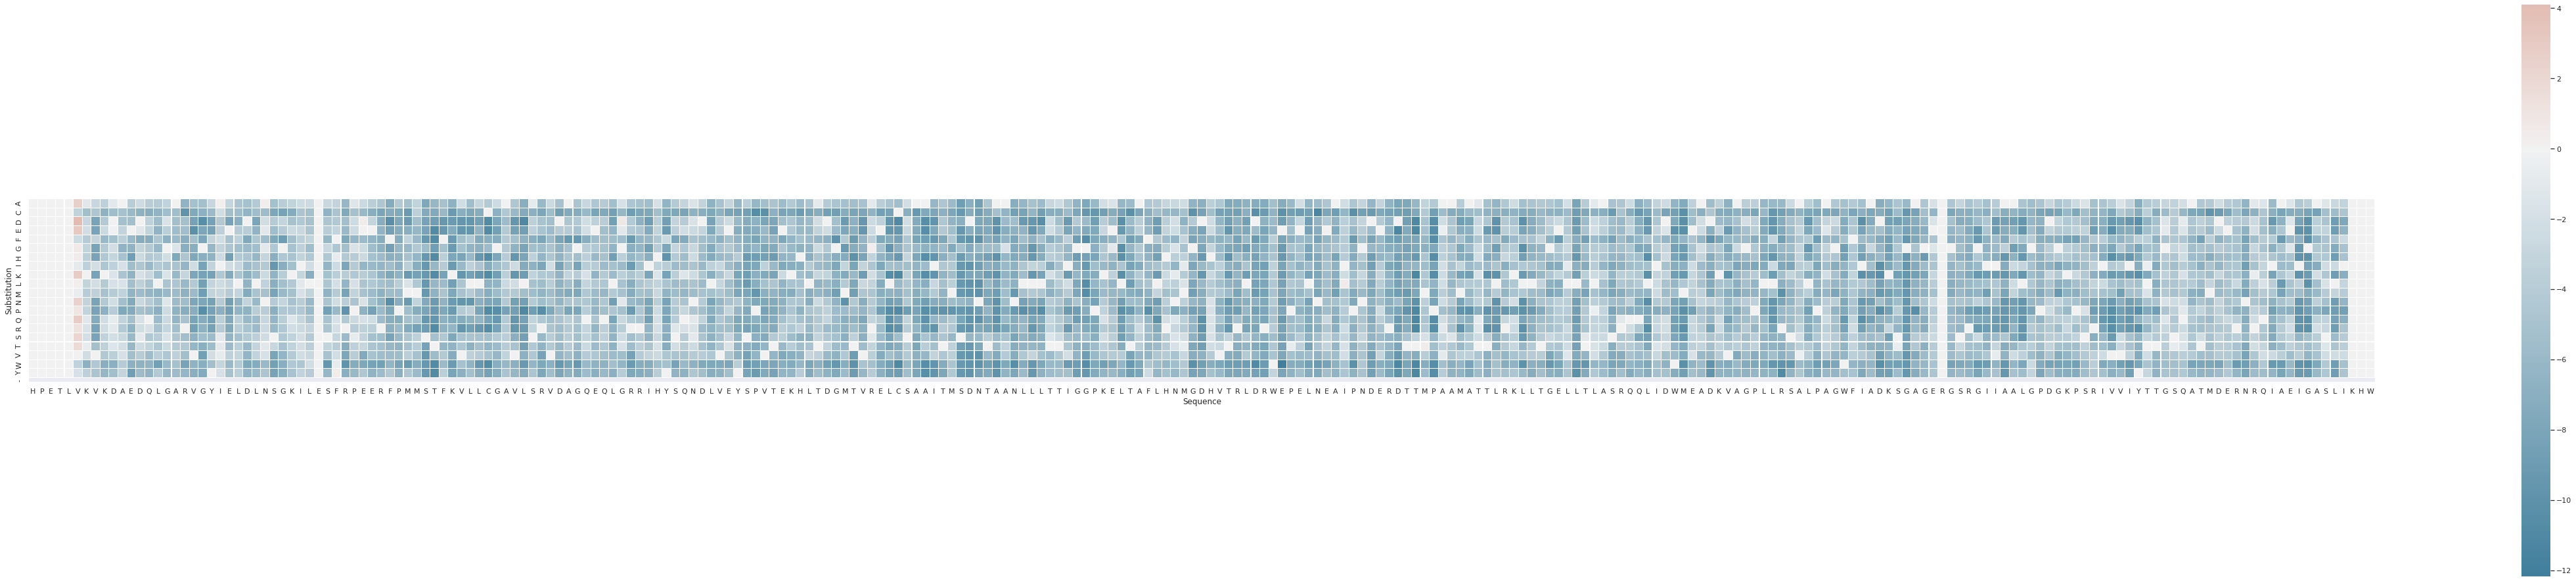

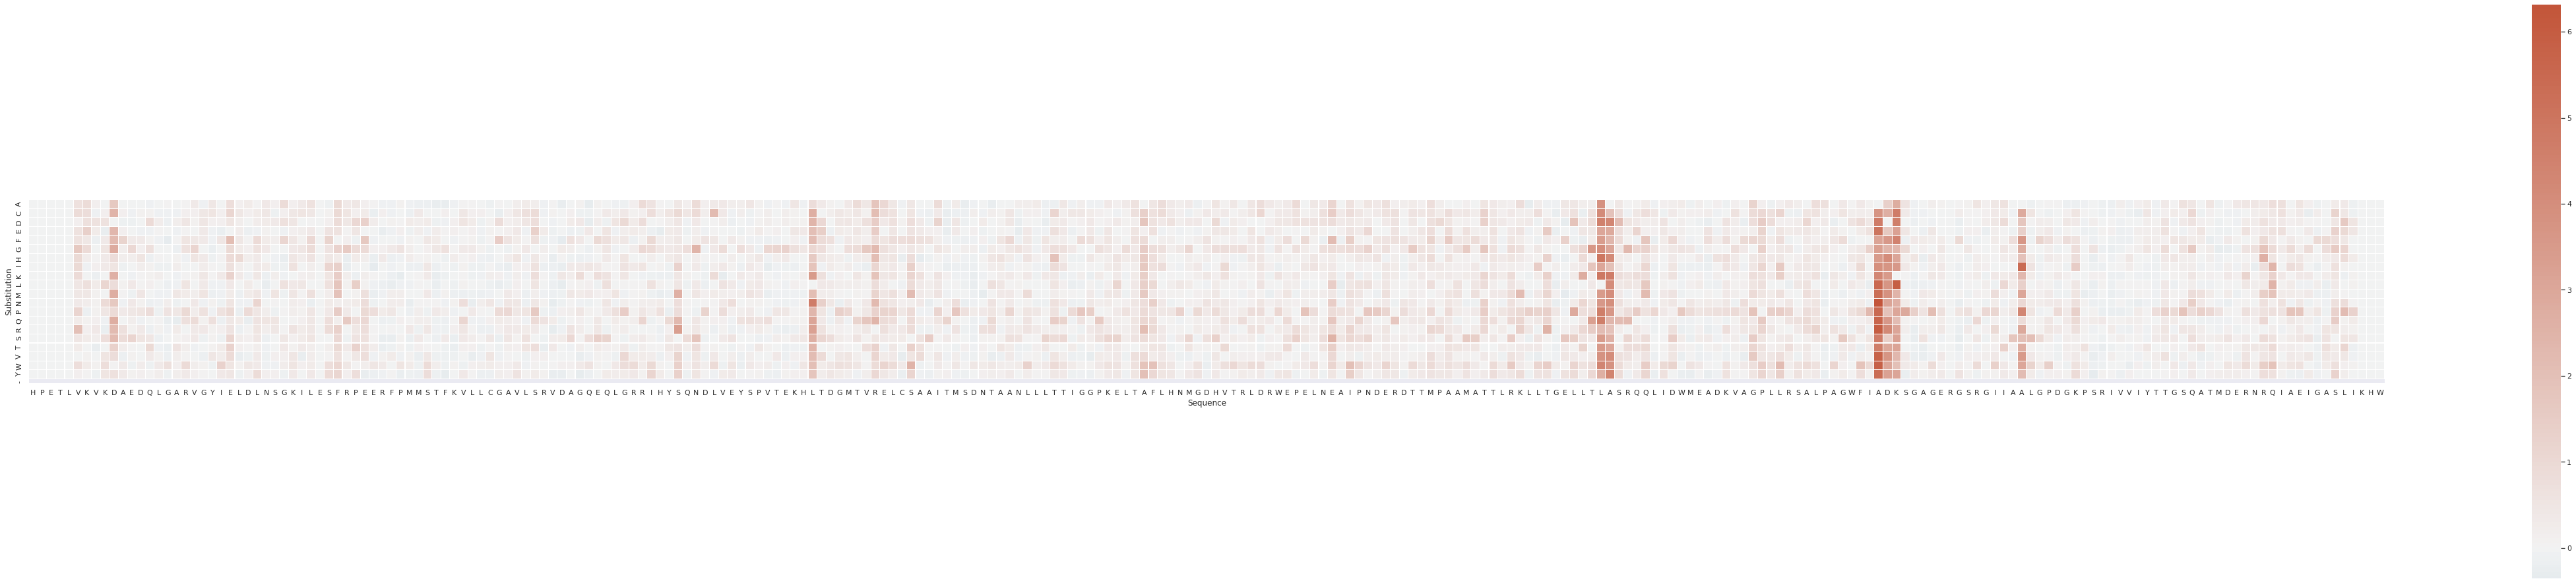

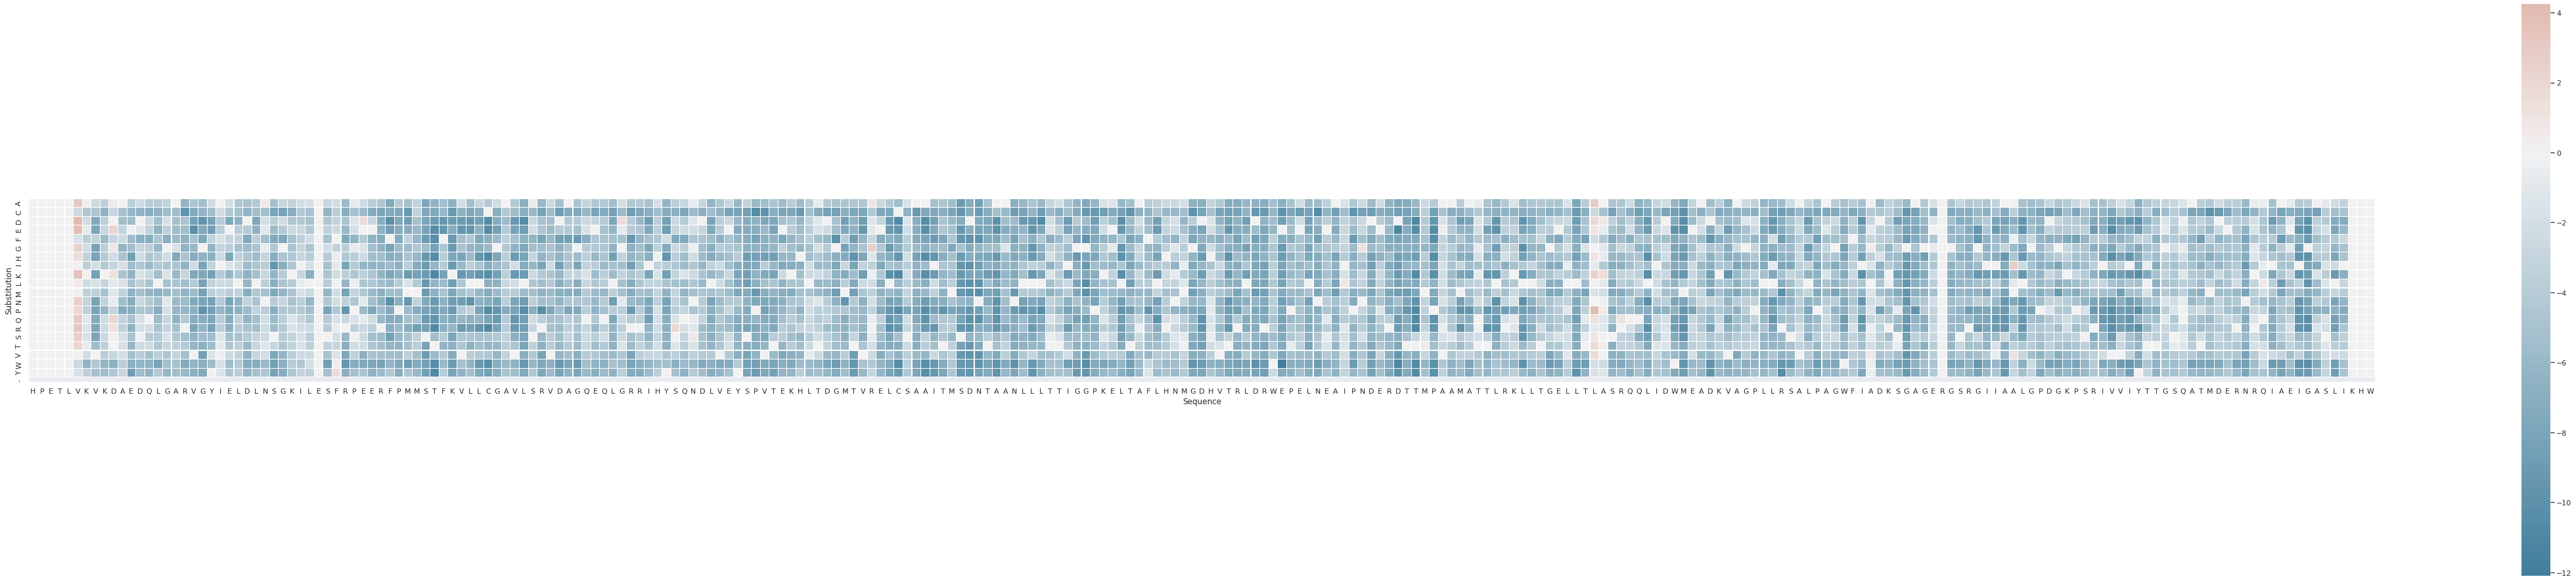

In [83]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set()
plt.figure(figsize = (80, 16))
sns.heatmap(heatmap_edca.t().numpy(), cmap = cmap, center = 0, xticklabels = nat_seq, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap(heatmap_ssqa.t().numpy(), cmap = cmap, center = 0, xticklabels = nat_seq, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap(heatmap_both.t().numpy(), cmap = cmap, center = 0, xticklabels = nat_seq, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

In [59]:
rho_e

[nan,
 nan,
 nan,
 nan,
 nan,
 0.19780219780219782,
 0.027777777777777776,
 0.16666666666666666,
 0.027777777777777776,
 0.10101010101010102,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.019607843137254905,
 0.0,
 0.0,
 0.0,
 0.015625,
 0.20833333333333334,
 0.019607843137254905,
 0.0,
 0.23529411764705888,
 0.328125,
 0.109375,
 0.0,
 0.3611111111111111,
 0.0,
 0.171875,
 nan,
 0.45098039215686275,
 0.05333333333333332,
 0.0,
 0.0,
 0.15384615384615385,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.019607843137254905,
 0.0,
 0.0,
 0.0,
 0.1111111111111111,
 0.0,
 0.0,
 0.0,
 0.0,
 0.453125,
 0.03921568627450981,
 0.0,
 0.28,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.41333333333333333,
 0.05555555555555555,
 0.01333333333333333,
 0.0,
 0.019607843137254905,
 0.0,
 0.0,
 0.0,
 0.15476190476190477,
 0.0,
 0.05333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2727272727272727,
 0.2857142857142857,
 0.0,
 0.0,
 0.0,
 0.0,
 0.027777777777777776,
 0.0833

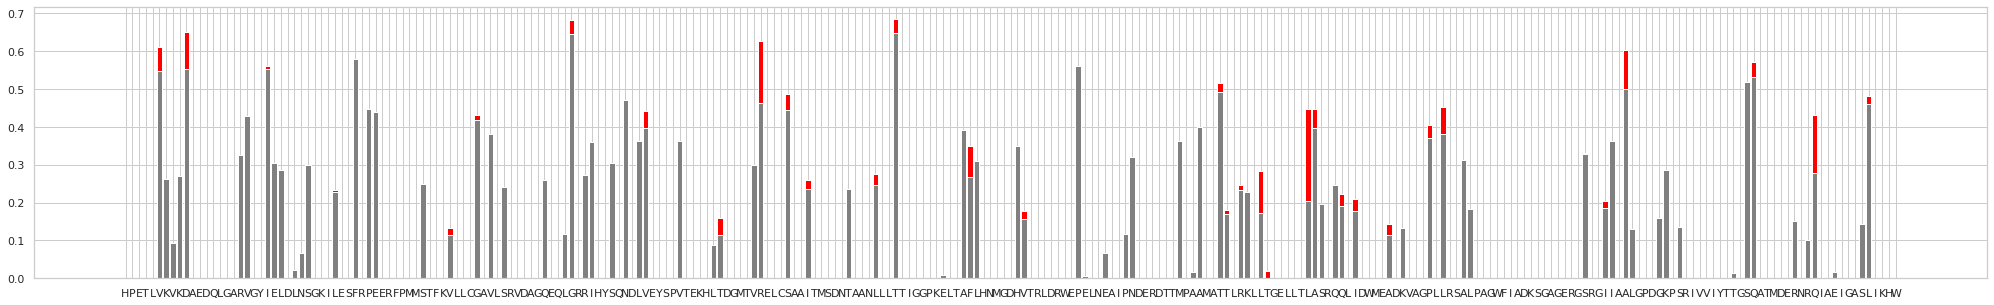

In [97]:
from scipy.stats import spearmanr,pearsonr

rho_e = []
rho_s = []
rho_b = []

for t,e,s,b in zip(target, heatmap_edca, heatmap_ssqa, heatmap_both):
    rho_e.append(pearsonr(t,e)[0])
    rho_s.append(pearsonr(t,s)[0])
    rho_b.append(pearsonr(t,b)[0])
    
plt.figure(figsize=(35,5))

plt.bar(range(len(rho_b)), [max(0,x) for x in rho_b], color = "red")
plt.xticks(range(len(rho_b)), nat_seq)
plt.bar(range(len(rho_e)), [max(0,x) for x in rho_e], color = "gray")
plt.xticks(range(len(rho_e)), nat_seq)

plt.show()


In [96]:
rho_b

[nan,
 nan,
 nan,
 nan,
 nan,
 0.6811880693477367,
 0.21882153700534204,
 0.0994643350024282,
 0.2983930050072846,
 0.6590035768383312,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.37574765346045197,
 0.33817873900825596,
 nan,
 nan,
 0.570672505863777,
 0.2999628168314381,
 0.40465131911125596,
 nan,
 0.115614662603216,
 -0.03642590462960279,
 0.3278331416664251,
 nan,
 -0.2983930050072846,
 nan,
 0.3035492052466899,
 nan,
 -0.14451832825401997,
 0.49858823247636896,
 nan,
 0.40465131911125596,
 0.41628159793472796,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.43355498476205995,
 nan,
 nan,
 nan,
 0.21882153700534204,
 nan,
 nan,
 nan,
 0.33817873900825596,
 -0.06070984104933798,
 0.40465131911125596,
 nan,
 0.21786957734000087,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.2983930050072846,
 nan,
 0.043355498476206,
 0.21882153700534204,
 0.628654727904987,
 nan,
 0.43355498476205995,
 0.33817873900825596,
 nan,
 nan,
 0.2503130871608794,
 nan,
 0.41187723552395705,
 nan,
 0.33817873900825596,
 0.46245

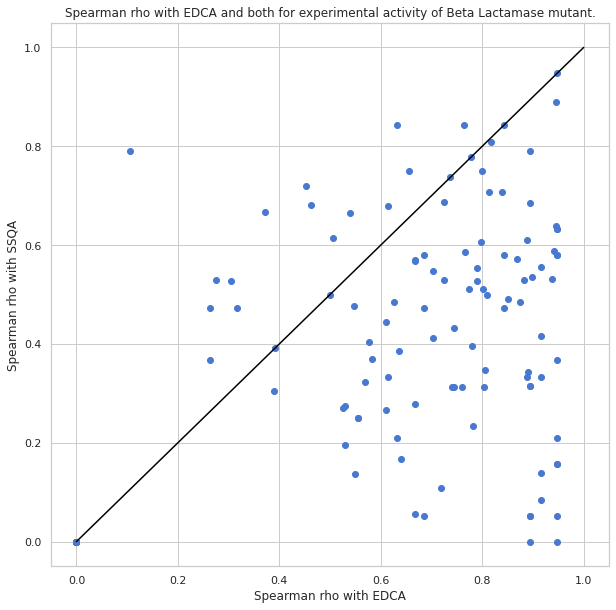

In [92]:
plt.figure(figsize=(10,10))
plt.scatter([max(0,x) for x in rho_e], [max(0,x) for x in rho_s])
plt.xlabel("Spearman rho with EDCA")
plt.ylabel("Spearman rho with SSQA")
plt.plot([0,1],[0,1], c = "black")
plt.title("Spearman rho with EDCA and both for experimental activity of Beta Lactamase mutant.")
plt.show()

In [86]:
data_scatter = pd.DataFrame()
data_scatter["rho_ssqa"] = heatmap_ssqa.flatten()
data_scatter["rho_edca"] = heatmap_edca.flatten()
data_scatter["rho_both"] = heatmap_both.flatten()

data_scatter["exp"] = target.flatten()

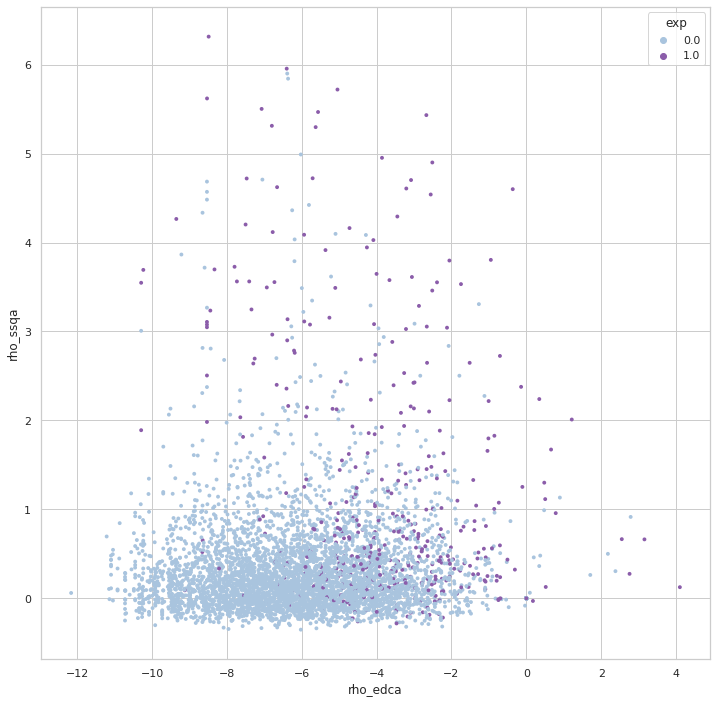

In [89]:
plt.figure(figsize= (12, 12))
sns.set(style="whitegrid", palette="muted")

sns.scatterplot(data = data_scatter, x="rho_edca", y="rho_ssqa",hue="exp", s=15,
                sizes=(1, 8), linewidth=0, palette = "BuPu")

plt.show()

In [116]:
density_map

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [0.2252357, 0.2252357, 0.2252357, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]])

In [129]:
stepx, stepy = 50, 30
mx, Mx, my, My = min(data_scatter.rho_edca), max(data_scatter.rho_edca), min(data_scatter.rho_ssqa), max(data_scatter.rho_ssqa)
px = (Mx-mx)/stepx
py = (My-my)/stepy
density_map = -6 * np.ones((stepx, stepy))
for i in range(N_step):
    for j in range(N_step):
        ds = data_scatter[(data_scatter.rho_edca >= mx + i*px) & (data_scatter.rho_edca < mx + i*px + px) & (data_scatter.rho_ssqa >= my + j*py) & (data_scatter.rho_ssqa < my + i*py + py)]["exp"]
        if len(ds)>0:
            density_map[i,j] = ds.mean() 
density_map = density_map.T

<AxesSubplot:>

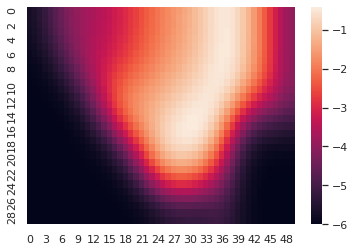

In [130]:
from scipy.ndimage import gaussian_filter
sns.heatmap(gaussian_filter(density_map,3))

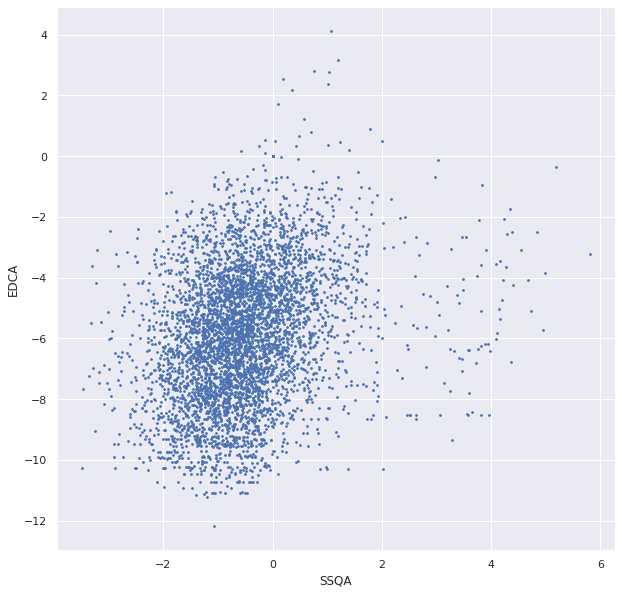

In [86]:
plt.figure(figsize=(10,10))
plt.scatter(heatmap_ssqa, heatmap_edca, s=3)
plt.xlabel("SSQA")
plt.ylabel("EDCA")
plt.show()

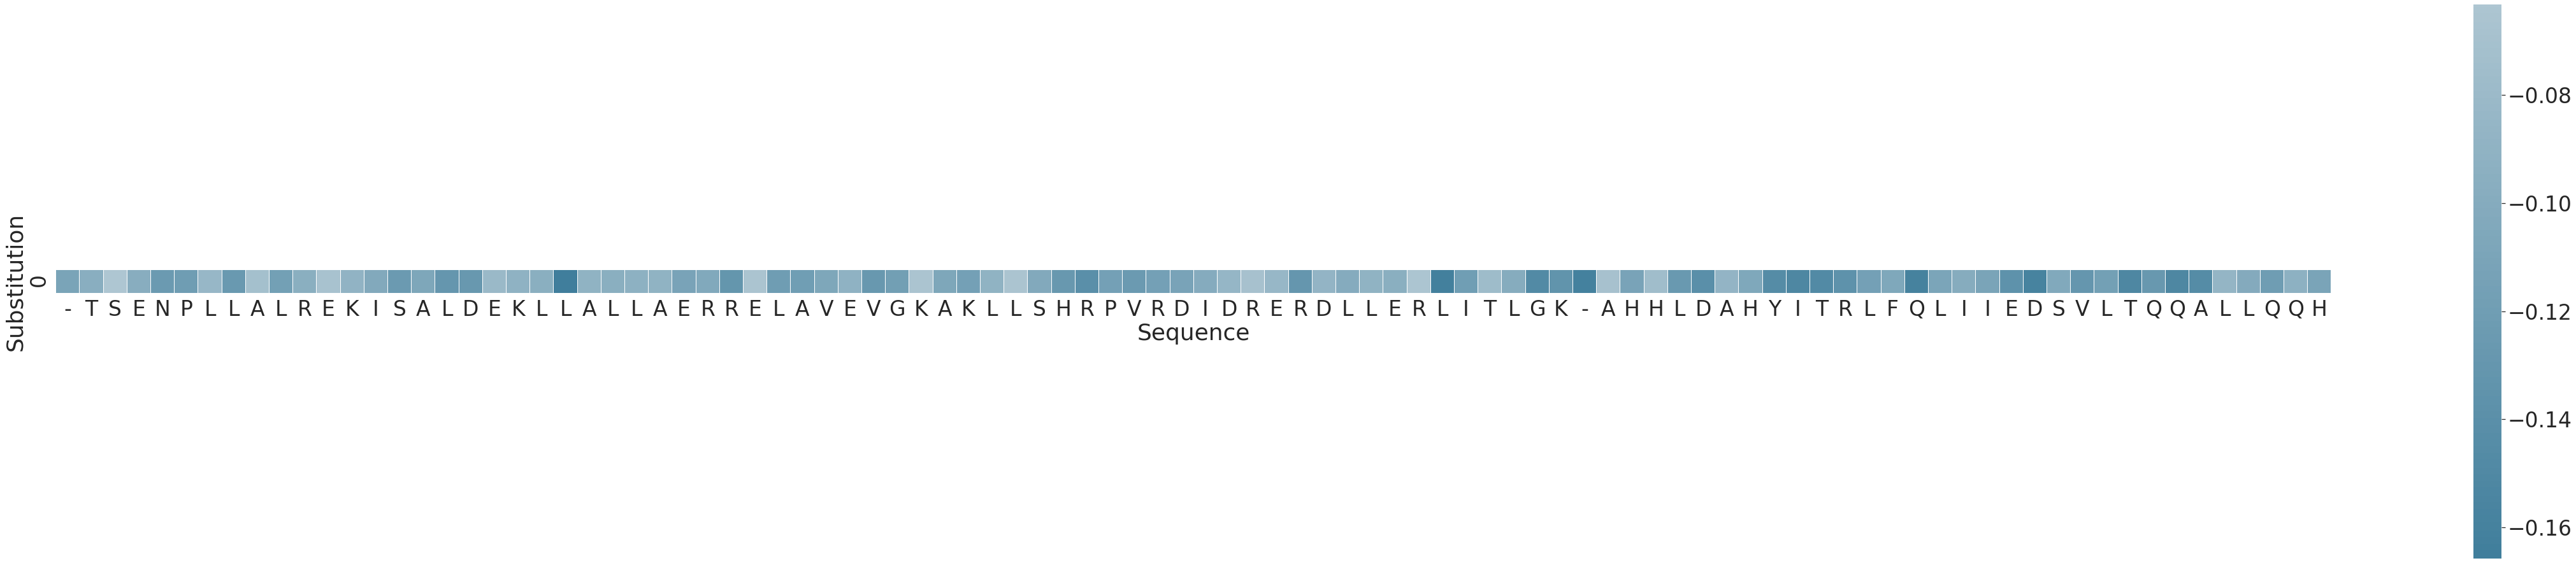

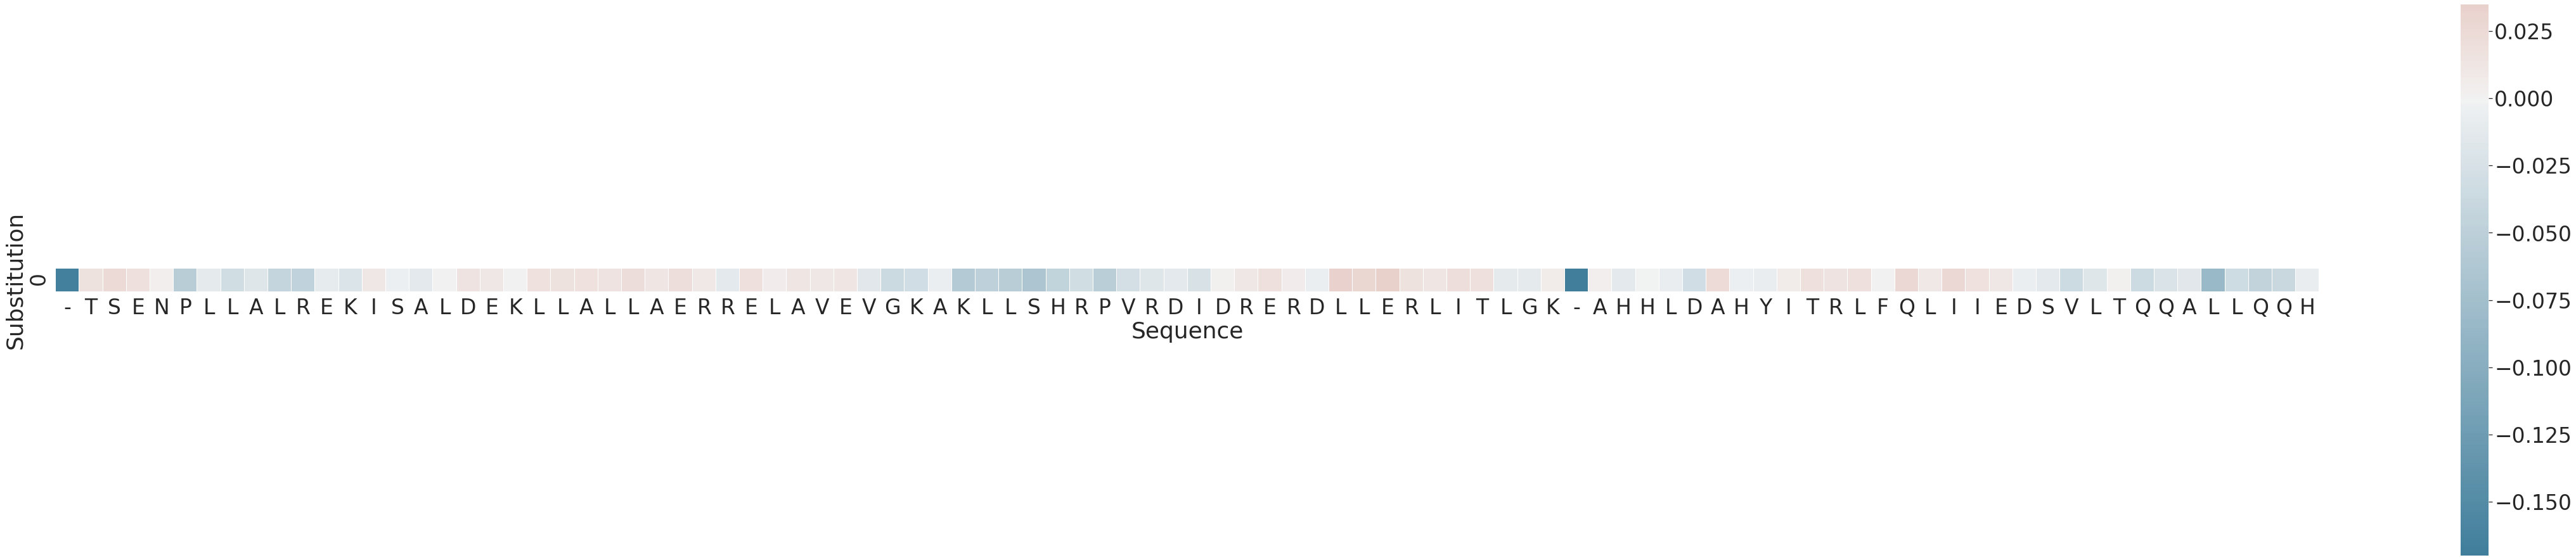

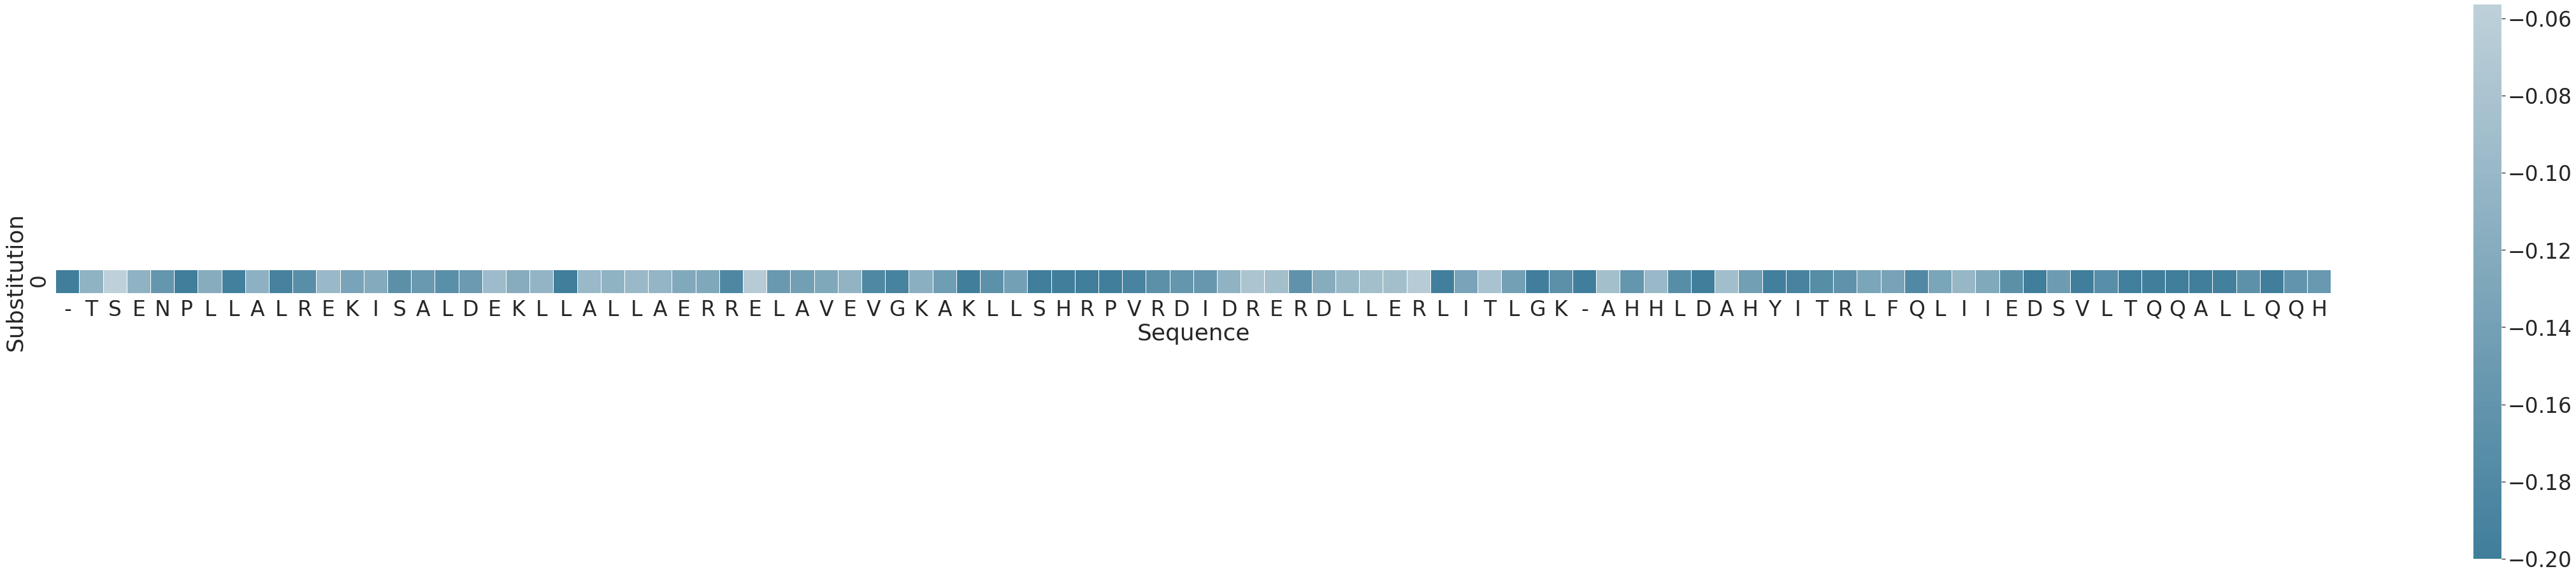

In [201]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale = 3)
plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_edca.T-ref_edca).mean(0)[None].numpy(), cmap = cmap, center = 0, xticklabels = eccm, #yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_ssqa.T-ref_ssqa).mean(0)[None].numpy(), cmap = cmap, center = 0, xticklabels = eccm, #yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_both.T-ref_both).mean(0)[None].clamp(-0.2).numpy(), cmap = cmap, center = 0, xticklabels = eccm, #yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

## RBM with rejection

In [248]:
import os
all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]
all_files.sort()

all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]

all_files = ['rbm_local_rejection_sampling_T_0.5',
             'rbm_local_rejection_sampling_T_0.6',
             'rbm_local_rejection_sampling_T_0.65',
            'rbm_local_rejection_sampling_T_0.7',]

In [249]:
all_ssqa_sup, all_ssqa_unsup, all_edca, all_both = [],[],[],[]
for filename in all_files:
    ssqa_sup, ssqa_unsup, edca_, both = [],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    
    for i in tqdm(range(len(x)//batch_size + 1)):
        x_ = x[i*batch_size:(i+1)*batch_size]
        e = model1.integrate_likelihood({"sequence":x_}, "hidden").detach()/data_rbm.size(-1) - model1.Z
        edca_.append(e)
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(x_[:,1:])
        ssqa_unsup.append(torch.tensor(pmunsup.detach()))
        ssqa_sup.append(torch.tensor((dpsup + pmsup)))
        both.append(torch.tensor((1.3 * e.numpy()+dpsup + pmsup)))
    all_ssqa_sup.append(torch.cat(ssqa_sup,0))
    all_ssqa_unsup.append(torch.cat(ssqa_unsup,0))
    all_edca.append(torch.cat(edca_,0))
    all_both.append(torch.cat(both,0))
all_ssqa_sup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_sup],0)
all_ssqa_unsup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_unsup],0)
all_edca = torch.cat([t.view(1, *t.size()) for t in all_edca],0)
all_both = torch.cat([t.view(1, *t.size()) for t in all_both],0)

100%|██████████| 1/1 [00:34<00:00, 34.61s/it]


In [288]:
(all_both).float().mean(1)

tensor([-0.2786, -0.2223, -0.0402, -0.5049])

In [284]:
df = pd.DataFrame(columns = ["val", "Rejection"], index = range(1500))
df["val"] = (all_both.view(-1))[:1500]
df["Rejection"][:499] = "T = 0 (no rejection)"
df["Rejection"][500:999] = "T = 0.6 (low rejection)"
df["Rejection"][1000:1499] = "T = 0.65 (high rejection)"
#df["cat"][1500:] = "T = 0.7"

In [273]:
["T = 0 (no rejection)", "T = 0.6 (low rejection)", "T = 0.65 (high rejection)"]

['T = 0 (no rejection)',
 'T = 0.6 (low rejection)',
 'T = 0.65 (high rejection)']

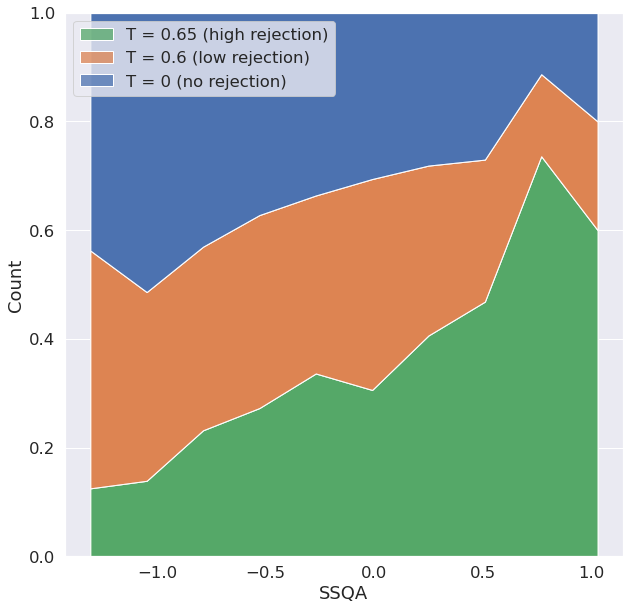

In [287]:
sns.set(style="white")
colors = "rgb"
sns.set(font_scale = 1.5)

plt.figure(figsize=(10,10))
for i,m in enumerate((all_ssqa_sup/2)):
    sns.histplot(df, x="val", stat="count", hue = "Rejection", bins = 10, multiple = "fill", element="poly", legend = False)
    #plt.ylim(0, 0.8)
plt.xlabel("SSQA")
plt.legend(["T = 0 (no rejection)", "T = 0.6 (low rejection)", "T = 0.65 (high rejection)"][::-1], loc='upper left')
#plt.xlim(0,0.8)
plt.show()

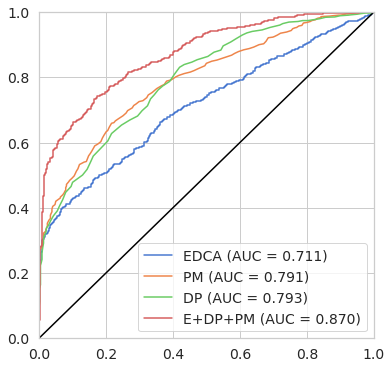

In [34]:
cond = (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df.edca > -25)
y = torch.tensor(df["is_active"][cond].values)
pred_dot = df["pred_dot"][cond]
pred_matching = df["pred_matching"][cond]
pred_dot_unsupervised = df["pred_dot_unsupervised"][cond]
pred_matching_unsupervised = df["pred_matching_unsupervised"][cond]
edca = torch.exp(torch.tensor(df["edca"][cond].values))

m1 = torch.tensor(pred_dot_unsupervised.values)
m2 = torch.tensor(pred_matching_unsupervised.values)
m3 = torch.tensor(pred_dot.values)
m4 = torch.tensor(pred_matching.values)
         
(wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature([edca, m1, m2, m3, m4], y)

legs = []
plt.figure(figsize=(6,6))

fpr, tpr, _ = roc_curve(1-y, -edca)
plt.plot(fpr, tpr)
legs.append(f"EDCA (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m4)
plt.plot(fpr, tpr)
legs.append(f"PM (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m3)
plt.plot(fpr, tpr)
legs.append(f"DP (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -(ws_e * edca  + ws_dp * m3 + ws_pm * m4))
plt.plot(fpr, tpr)
legs.append(f"E+DP+PM (AUC = {auc(fpr, tpr):.3f})")

plt.legend(legs,fontsize=14)
#plt.title("Supervised SSQA on low energy samples (EDCA < 25)", fontsize=16)
plt.plot([0,1], [0,1], c="black")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

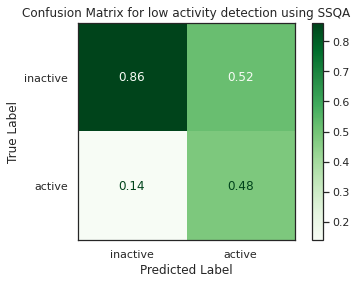

In [154]:
THRES = 0.45
y = df[(df.origin == "DCA") & (-df.edca < 25)]["ssqa"]
gt = df[(df.origin == "DCA")& (-df.edca < 25)]["is_active"]
cm = confusion_matrix(gt, np.array(y > THRES, dtype = int), normalize = "pred")
sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
T1 = np.linspace(1, 3, 25)
T2 = np.linspace(0.3, 0.6, 25)
best_acc, t = 0,None
for t1 in T1:
    for t2 in T2:
        sub = df[(df.origin == "DCA") & (-df.edca < t1) & (df["ssqa"] > t2)].is_active
        acc = sub.mean()
        N = len(sub)
        if acc > best_acc:
            best_acc = acc
            t = (t1, t2, N, acc)
best_acc

0.7980769230769231

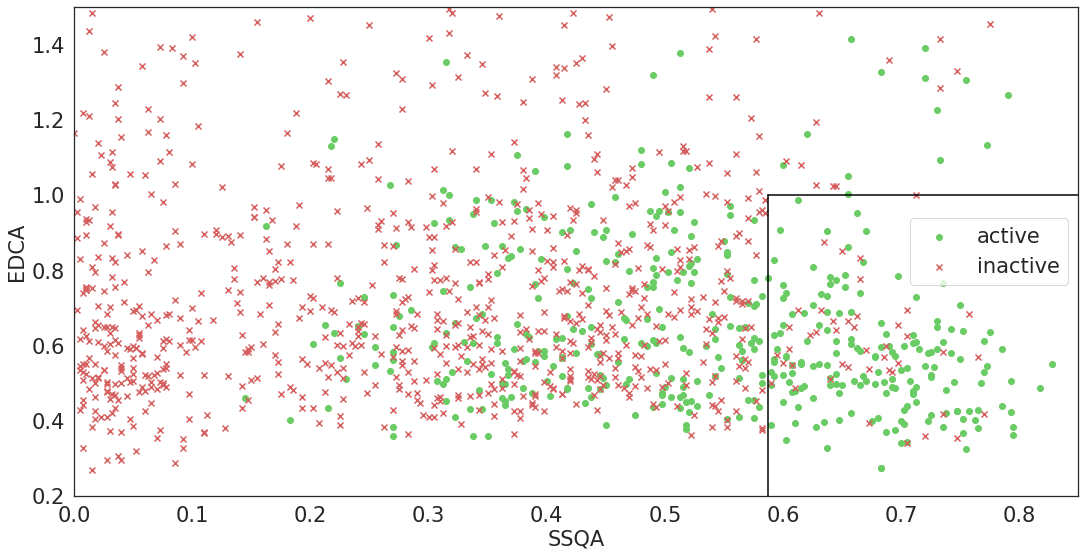

In [54]:
plt.figure(figsize=(18,9))
plt.scatter(df["ssqa"][(df.origin == "DCA") & (df.is_active == 1)],
            -df["edca"][(df.origin == "DCA") & (df.is_active == 1)],
            c="g", marker="o")
plt.scatter(df["ssqa"][(df.origin == "DCA") & (df.is_active == 0)], 
            -df["edca"][(df.origin == "DCA") & (df.is_active == 0)], 
             c="r", marker="x")
plt.legend(["active", "inactive"], fontsize=21)
plt.plot((t[1],t[1]), [-50,t[0]], c = "black")
plt.plot([t[1],100], (t[0],t[0]), c = "black")
plt.xlabel("SSQA", fontsize=21)
plt.ylabel("EDCA", fontsize=21)
plt.ylim(0.2,1.5)
plt.xlim(0,0.85)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
#plt.title("SSQA and EDCA of generated samples (85% active in the black box)", fontsize=21)
plt.show()

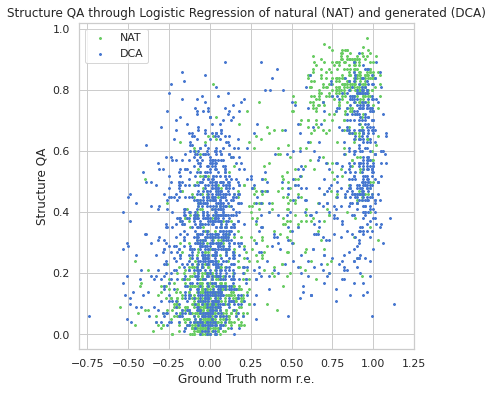

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(df["norm r.e."][(df.origin == "DCA") & df.is_active], 
            comb[df.origin == "NAT"], c="g", marker="o", s=4)
plt.scatter(df["norm r.e."][(df.origin == "DCA") & (~df.is_active)], 
            comb[df.origin == "DCA"], c="r", marker="x", s=4)
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("Structure QA")
plt.xlim(-0.8, 1.25)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.origin == "NAT")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="g", marker="x")
plt.scatter(df[(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.origin == "DCA")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="b", marker="x")
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("E_DCA")
# plt.xlim(-0.8, 1.25)
# plt.ylim(-0.01, 0.85)
plt.title("E_DCA of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["EDCA (rel. to EcCM)"].values, c="g", marker="o", s=5)
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["EDCA (rel. to EcCM)"].values, c="r", marker="x", s=5)
plt.legend(["active", "inactive"], loc = 1)
plt.xlabel("Structure QA")
plt.ylabel("E_DCA")
plt.ylim(-25, 75)
plt.title("Structure E_DCA function of Structure QA")

plt.show()

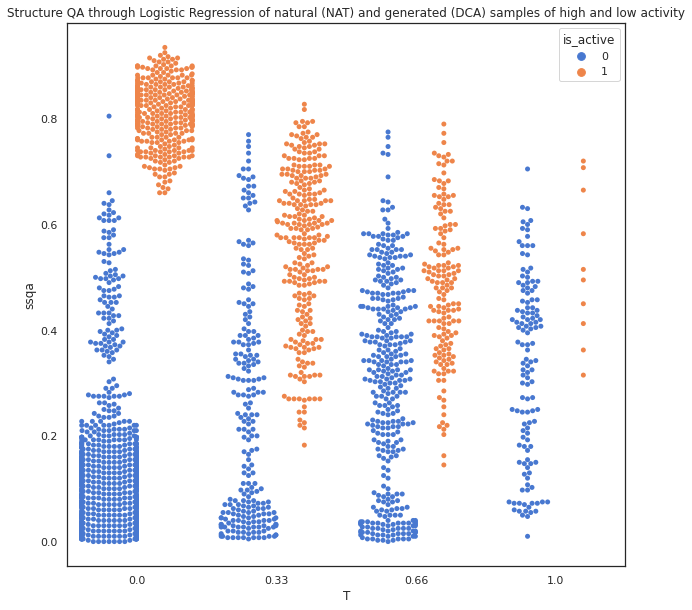

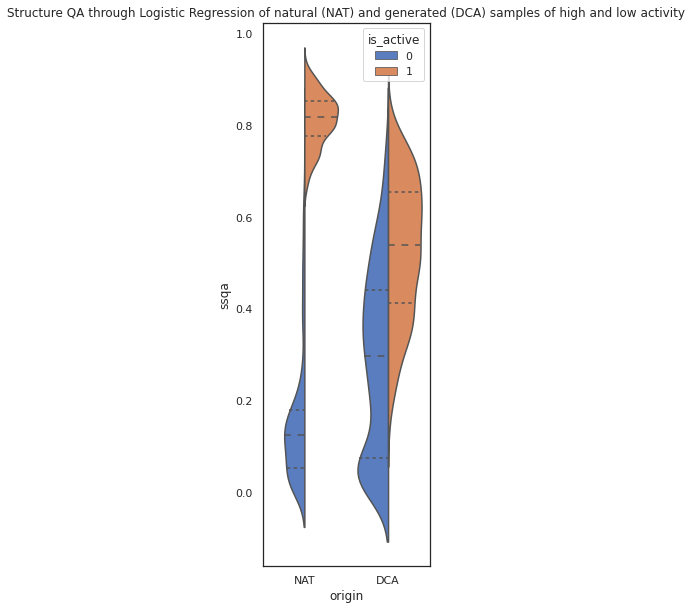

In [57]:
plt.figure(figsize=(10,10))
sns.swarmplot(x = "T", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               palette = "muted",
               split = True,)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.01, 1)
plt.show()

plt.figure(figsize=(3,10))
sns.violinplot(x = "origin", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               inner = "quartile", 
               palette = "muted",
               split = True,)

plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.2, 1)
plt.show()